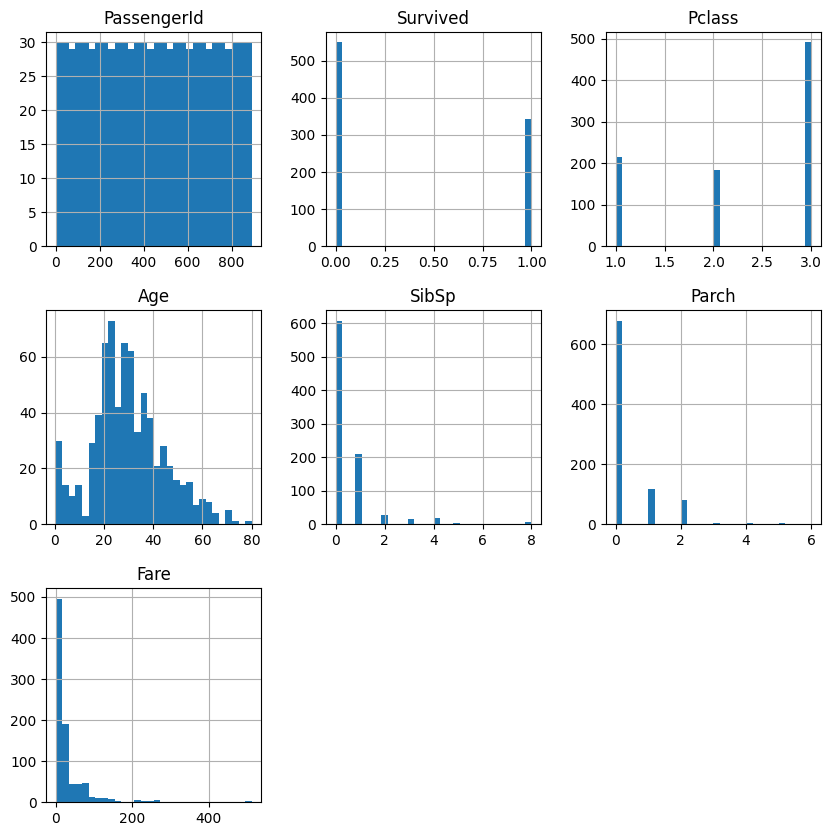

In [16]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
def read_csv (path):
    train_data = pd.read_csv(path)
    return train_data

train_data =  read_csv('train.csv')
train_data_num = train_data.drop(columns=['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'])
train_data_text = train_data.drop(columns=['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'])
train_data_target = train_data['Survived']
corr_matrix = train_data_num.corr()

train_data_num.hist(figsize=(10, 10), bins=30)
plt.show()